#***`Trending YouTube Video Analysis..!`***


---



A vast analysis of various aspects in the world of YouTube, with detailed and informative plots, lots of fun insights and some magic of machine learning, trying to answer as many questions as possible.

What questions we posed ourselves?


1.   What are the most famous channels?
2.   What are the most liked videos?
3.   What are the most hated videos?
4. Which country has the most videos posted?
5. What are the top 10 videos in each category based on views?
6. How do views vary over the days of the week?(Weekend vs weekdays)	

and many more ....



---



> Language: Python


> Algorithms: Random forest, Decision Tree, XGB Boost Guassian and KNN classifiers




> Methods used: Classification, Ensemble Learning Methods.


> Predictions: Missing Categories of Videos













---







In [62]:
%pwd

'C:\\Users\\lsandh3\\Desktop\\Youtube-Analysis'

In [63]:
import pandas as pd

In [64]:
dir = "C:/Users/lsandh3/Desktop/Youtube-Analysis/YT_Data"#Directory of datasets
model_dir = "C:/Users/lsandh3/Desktop/Youtube-Analysis"#Directory of models

##Importing Required Libraries

In [65]:
import os
import re
import csv
import sys
import json
import plotly
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from math import log10
from io import StringIO
from matplotlib import cm
import plotly.express as px 
import plotly.graph_objs as go 
import plotly.offline as pyoff
import matplotlib.pyplot as plt
from warnings import simplefilter
from IPython.core.display import HTML,display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

C:\Users\lsandh3\AppData\Local\Temp\ipykernel_24960\3327491529.py:20: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [66]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [67]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [68]:
%matplotlib inline
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)
init_notebook_mode(connected=True)

In [69]:
!pip install wordcloud

In [70]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lsandh3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lsandh3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lsandh3\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


A function which has the css styling for plots

In [71]:
def set_css():
  return display(HTML("""<style>
  #output-body {
    display: flex;
    align-items: center;
    justify-content: center;
    background-color:white;
    color:black;
    }
  .output_text pre{
    margin-right : 70px;
    color: black;
    font-weight: bold;
    /* font-size: 10px; */
  }

}  </style>"""))

#Data Exploration

##Data Processing

In [72]:
def process_date_attributes(data):
  data["publish_time"] = pd.to_datetime(data["publish_time"])
  data["trending_date"] = pd.to_datetime(data["trending_date"],format="%y.%d.%m")
  data["trend_year"]=data["trending_date"].apply(lambda time:time.year)
  data["trend_date"] = data["trending_date"].apply(lambda time: time.day)
  data["trend_month"]=data["trending_date"].apply(lambda time:time.month)
  data["publish_year"]=data["publish_time"].apply(lambda time:time.year)
  data["publish_month"]=data["publish_time"].apply(lambda time:time.month)
  data["publish_day"]=data["publish_time"].apply(lambda time:time.day)
  data["publish_weekday"]=data["publish_time"].apply(lambda time:time.dayofweek)
  data["publish_hour"]=data["publish_time"].apply(lambda time:time.hour)
  return data

In [73]:
def match_categories(x,dictionary): #function to get the categories
    try:
        return dictionary[str(x)]
    except:
        return "Unknown"

##Data Cleaning

In [74]:
def data_cleaning(data):
  if data['description'].isnull().sum()>0:
    data['description'] = data['description'].replace(np.nan,"") #Replacing the NaN values in the "Description" column with an empty string
  data = data.sort_values('video_id').drop_duplicates(subset=['trending_date', 'title'], keep='last')
  data = data.drop(columns=["publish_time","category_id"],axis=1)
  return data

##Loading the datasets

In [75]:
def load_data(file_path): 
    ch_file=file_path
    Country_code = ch_file[0:2]
    path=os.path.join(dir,ch_file)
    input_df=pd.read_csv(path,encoding='mbcs')
    title_dict={}
    json_path=os.path.join(dir,(Country_code+str('_category_id.json')))
    json_input_df=pd.read_json(json_path)
    input_df['region']=Country_code
    for dict_a in json_input_df['items']:
        title_dict[dict_a['id']]=dict_a['snippet']['title'] 

    input_df = process_date_attributes(input_df) #Calling the function to process the date columns.
    input_df['category']=input_df['category_id'].apply(match_categories,args=(title_dict,))
    input_df = data_cleaning(input_df)
    return input_df

In [76]:
set_css()
con_list = []
cons_dict = {}
t_df = pd.DataFrame()
for dirname, _, filenames in os.walk(dir):
    print("................................")
    for paths in filenames:
        if paths.lower().endswith(".csv"):
          con_list.append(paths[0:2])
          x = load_data(paths)
          globals()[str(paths[0:2])] = x
          cons_dict[str(paths[0:2])]=x
          print("------Created",paths[0:2],"DataFrame------")
    print("Processed all available Datasets")

................................
------Created CA DataFrame------
------Created DE DataFrame------
------Created FR DataFrame------
------Created GB DataFrame------
------Created IN DataFrame------
------Created US DataFrame------
Processed all available Datasets


##Checking and filling the missing categories

In [77]:
for i,j in cons_dict.items():
  print(i,j[j.category=="Unknown"].value_counts().sum())

CA 74
DE 256
FR 114
GB 90
IN 103
US 0


In [78]:
def get_unique_categ(data):
  cat_x = data['category'].unique()
  cat_y = list(cat_x)
  dictc = {}
  for i in range(0,len(cat_y)):
    dictc[i] = cat_y[i]
  return dictc,cat_x

In [79]:
from tqdm import tqdm
def fill_categ_unknown():
  t_list = [] 
  con_dict={}
  for con,cdf in tqdm(cons_dict.items()):
    print(con)
    if con!="US":
#       cv_path = model_dir + '/' + con + '_vector.pkl'
      cv_path = os.path.join(model_dir,(con+'_vector.pkl'))
      print(model_dir)
      print(cv_path)
      em_path = os.path.join(model_dir,(con+'_model.pkl'))
      vector = pickle.load(open(cv_path, 'rb'))
      model = pickle.load(open(em_path, 'rb'))
      cat_a,_ = get_unique_categ(cdf)
      print("\n----------Filling in unknowns for",con,"----------\n")
      for index,row in cdf.iterrows():
        if row["category"]=="Unknown":
          t=row["title"]
          t=[t]
          txc = vector.transform(t)
          pred = model.predict(txc)
          pred = list(pred)[0]
          cdf.at[index,'category'] = cat_a[pred]
      t_list.append(cdf)
      cdf = cdf.drop(columns=['video_id','region'],axis=1)
      globals()[con]=cdf
      con_dict[con] = cdf
    else:
      t_list.append(cdf)
      cdf = cdf.drop(columns=['video_id','region'],axis=1)
      globals()[con]=cdf
      con_dict[con] = cdf
  print("\n----------filled all unknowns in category----------")
  return t_list,cons_dict
t_list,con_dict= fill_categ_unknown()
t_df = pd.concat(t_list,ignore_index=True)
tdf = t_df
tdf.name = "The 6 Countries"
print("................................")
print("tdf  is the cumulative DataFrame")

  0%|          | 0/6 [00:00<?, ?it/s]

CA
C:/Users/lsandh3/Desktop/Youtube-Analysis
C:/Users/lsandh3/Desktop/Youtube-Analysis\CA_vector.pkl

----------Filling in unknowns for CA ----------



 17%|█▋        | 1/6 [00:10<00:54, 10.84s/it]

DE
C:/Users/lsandh3/Desktop/Youtube-Analysis
C:/Users/lsandh3/Desktop/Youtube-Analysis\DE_vector.pkl

----------Filling in unknowns for DE ----------



 33%|███▎      | 2/6 [00:33<01:10, 17.72s/it]

FR
C:/Users/lsandh3/Desktop/Youtube-Analysis
C:/Users/lsandh3/Desktop/Youtube-Analysis\FR_vector.pkl

----------Filling in unknowns for FR ----------



 50%|█████     | 3/6 [00:47<00:47, 15.99s/it]

GB
C:/Users/lsandh3/Desktop/Youtube-Analysis
C:/Users/lsandh3/Desktop/Youtube-Analysis\GB_vector.pkl

----------Filling in unknowns for GB ----------



 67%|██████▋   | 4/6 [00:56<00:26, 13.30s/it]

IN
C:/Users/lsandh3/Desktop/Youtube-Analysis
C:/Users/lsandh3/Desktop/Youtube-Analysis\IN_vector.pkl

----------Filling in unknowns for IN ----------



100%|██████████| 6/6 [01:06<00:00, 11.15s/it]


US

----------filled all unknowns in category----------
................................
tdf  is the cumulative DataFrame


In [80]:
for i,j in con_dict.items():
  print(i,j[j.category=="Unknown"].value_counts().sum())

CA 0
DE 0
FR 0
GB 0
IN 0
US 0


##Select a Region


In [81]:
try:
  print("Available Countries for analysis ->",con_list)
  print("\n")
  x=input(prompt="Choose one country for using it all through analysis or hit enter\n")
  x = x.upper()
  1/len(x)
  df = con_dict[x]
  df.name = x
  print("\nThe analysis will be done on",x,"and it is stored as -> df")
except:
  print("\nPlease don't forget to input required country")

Available Countries for analysis -> ['CA', 'DE', 'FR', 'GB', 'IN', 'US']


Choose one country for using it all through analysis or hit enter
GB

The analysis will be done on GB and it is stored as -> df


In [82]:
df.name

'GB'

#Analysis

###Helper Functions

In [83]:
global countries  
countries = list(tdf.region.unique())

In [84]:
def show_values_on_bars(axs, h_v="v",*args):
    def show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                  x = p.get_x() + p.get_width() / 2 
                  y = p.get_y() + p.get_height() /8
                  value = int(p.get_height())
                  ax.text(x, y, value, ha="center",rotation=90) 
        elif h_v == "h":
            for p in ax.patches:
              if len(args)==0:
                x = p.get_x() + p.get_width() /2
                y = p.get_y() + p.get_height() /2
                value = int(p.get_width())
                ax.text(x, y, value, ha="left",va="center")
              else:
                x = p.get_x() + p.get_width() +0.4
                y = p.get_y() + p.get_height() /2
                value = int(p.get_width())
                ax.text(x, y, value, ha="left",va="center")
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            show_on_single_plot(ax)
    else:
        show_on_single_plot(axs)

In [85]:
months_choices = {}
global months_choices
for i in range(1,13):
    months_choices[i] = datetime.date(2008, i, 1).strftime('%B')

In [86]:
dict_cat,cat_x=get_unique_categ(df)

##Correlation Analysis

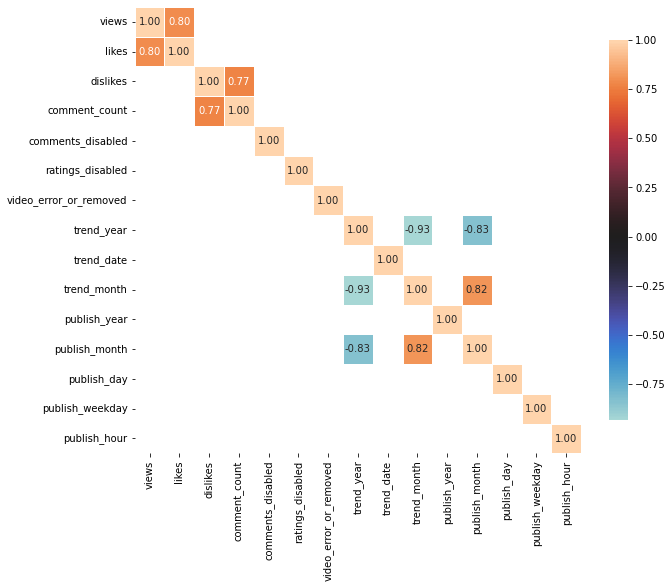

In [87]:
set_css()
def correlation_heatmap(data):
    correlations = data.corr()
    correlations = correlations[((correlations >= 0.75) | (correlations <= -0.75))]
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();  
correlation_heatmap(df)

In [88]:
l = ["views","likes","dislikes","comment_count","ratings_disabled","comments_disabled"]
corr = df[l].corr()
corr

,views,likes,dislikes,comment_count,ratings_disabled,comments_disabled
views,1.000000,0.795869,0.391823,0.466263,0.013608,-0.005950
likes,0.795869,1.000000,0.446529,0.743713,-0.032261,-0.041640
dislikes,0.391823,0.446529,1.000000,0.772129,-0.012506,-0.009141
comment_count,0.466263,0.743713,0.772129,1.000000,-0.021039,-0.034459
ratings_disabled,0.013608,-0.032261,-0.012506,-0.021039,1.000000,0.515109
comments_disabled,-0.005950,-0.041640,-0.009141,-0.034459,0.515109,1.000000


So from the data its evident that (views,likes) are well correlated, and (likes,comment_count) are well correlated

In [89]:
for x in corr.columns:
  for y in range(corr.shape[0]):
    if (corr[x][y] >= 0.75 and corr[x][y]<1):
      print((x,corr.columns[y])) 

('views', 'likes')
('likes', 'views')
('dislikes', 'comment_count')
('comment_count', 'dislikes')


Plots showing the correlation
between likes,views,dislikes


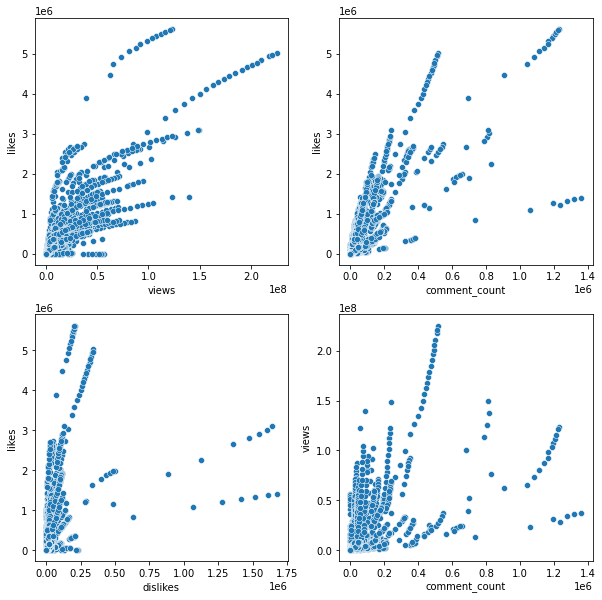

In [90]:
set_css()
def corr_plot(df):
    f,ax=plt.subplots(2,2,figsize=(10,10))
    sns.scatterplot(x='views',y='likes', data=df, ax=ax[0][0])
    sns.scatterplot(x='comment_count',y='likes', data=df, ax=ax[0][1])
    sns.scatterplot(x='dislikes',y='likes', data=df, ax=ax[1][0])
    sns.scatterplot(x='comment_count',y='views', data=df, ax=ax[1][1])
    print("Plots showing the correlation\nbetween likes,views,dislikes")
corr_plot(US)

##EDA w.r.t to Time Series

2018    27200
2017    11037
2015       93
2011       85
2014       66
2013       62
2016       58
2008       43
2007       37
2010       34
2012       14
2009       13


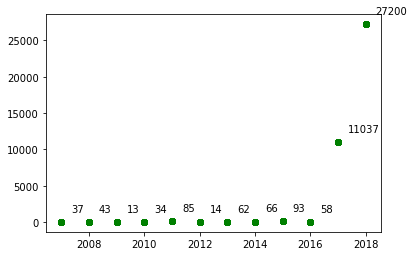

In [91]:
set_css()
def total_videos_per_year(data):
  x = list(data.publish_year.unique())
  y = []
  for i in x:
    y.append(data[data.publish_year==i].value_counts().sum())
  if len(x)>6:
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    for i, txt in enumerate(y):
      ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
      plt.scatter(x, y, marker='o', color='green')
  else:
    plt.pie(y,labels=x,autopct='%1.2f%%') 
  print(data["publish_year"].value_counts().to_string())
total_videos_per_year(df)

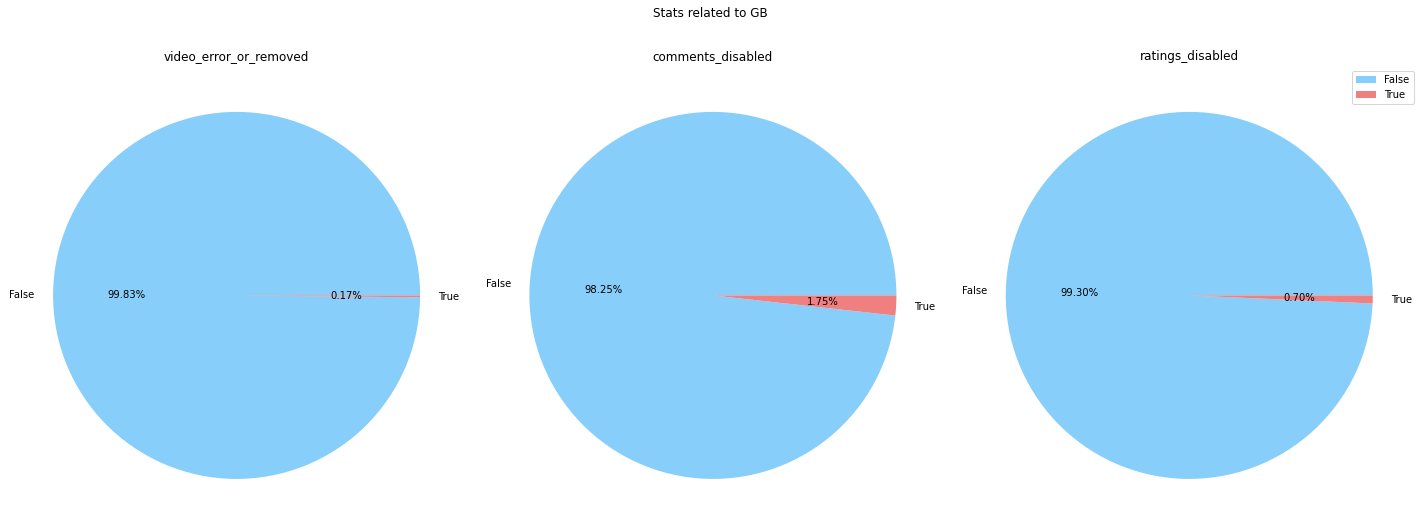

In [92]:
set_css()
def removed_stats(data):
  al=data.comments_disabled.unique()
  leg = ['video_error_or_removed','comments_disabled','ratings_disabled']
  data=[list(data.video_error_or_removed.value_counts()),list(data.comments_disabled.value_counts()),list(data.ratings_disabled.value_counts())]
  f,axi = plt.subplots(nrows=1,ncols=3)
  f.suptitle("Stats related to %s" %(df.name))
  f.set_size_inches(20,8)
  colors = ['lightskyblue', 'lightcoral']
  i=0
  for row in range(1):
    for col in range(3):
      patches=axi[col].pie(data[i],labels=al,autopct='%1.2f%%',colors=colors)
      axi[col].set_title(f'{leg[i]}')
      i=i+1
  plt.legend(al, loc="best")
  plt.tight_layout()
removed_stats(df)

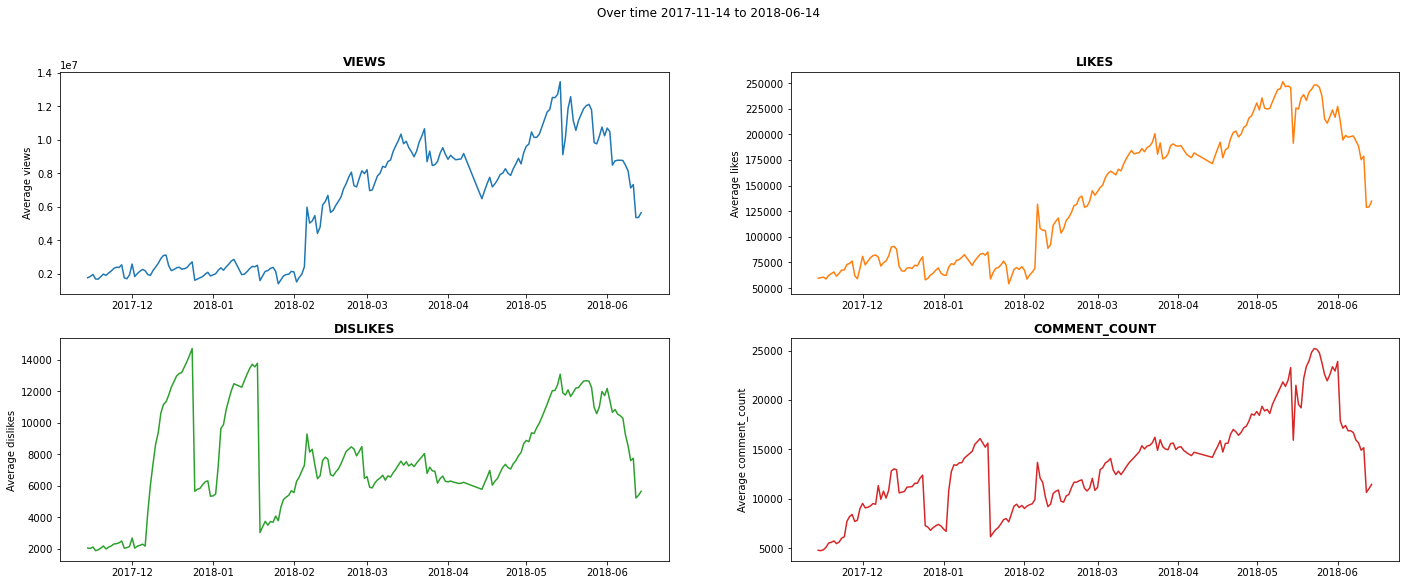

In [93]:
set_css()
def plot_time_period(data, var):
    l = var
    averages = data.groupby("trending_date").mean()
    f,ax = plt.subplots(nrows=2,ncols=2)
    my_colors = plt.rcParams['axes.prop_cycle']()
    f.suptitle("Over time %s to %s" %(min(data.trending_date).date(),max(data.trending_date).date()))
    f.set_size_inches(24,9)
    i=0
    for row in range(2):
      for col in range(2):
        ax[row,col].plot(averages.index.values,averages[var[i]],**next(my_colors))
        ax[row,col].set_ylabel("Average %s" %(l[i]))
        ax[row,col].set_title("%s" %(l[i]).upper(),weight='bold')
        ax[row,col].grid(False)
        i=i+1
plot_time_period(df,['views','likes','dislikes','comment_count'])

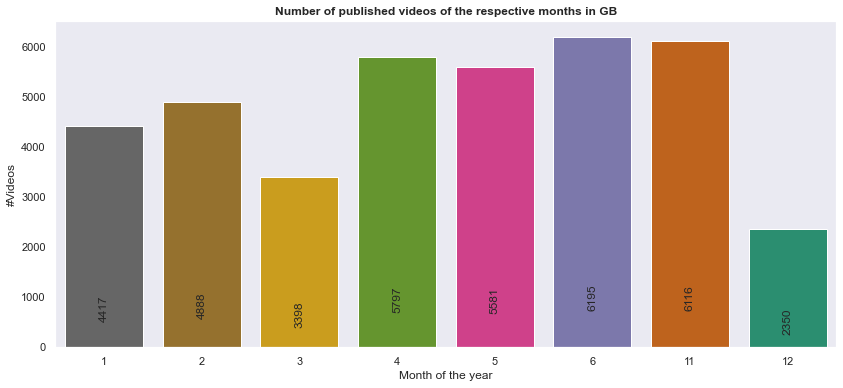

In [94]:
set_css()
def months_analysis(data):
  data2=data.sort_values(by=['trend_month'])
  data2 = data2['trend_month'].value_counts()
  sns.set(rc={'figure.figsize':(14,6)})
  a =sns.barplot(data2.index,sorted(data2),palette='Dark2_r')
  a.grid(False)
  a.set_title('Number of published videos of the respective months in %s' %(data.name),weight='bold')
  a.set_xlabel("Month of the year")
  a.set_ylabel("#Videos")
  show_values_on_bars(a,'v')
months_analysis(df)

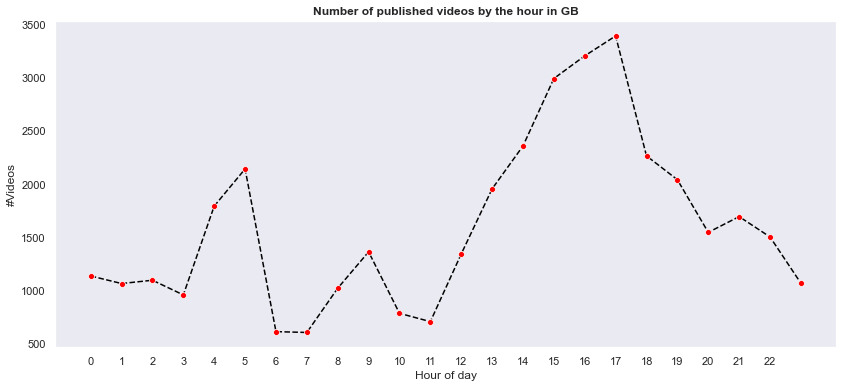

In [95]:
set_css()
def publish_hour_count_plot(data):
  by_hour = data.publish_hour.value_counts()
  sns.set(rc={'figure.figsize':(14,6)})
  a=np.arange(0,23)
  ax=sns.lineplot(by_hour.index,by_hour.values,color='black',ls='--',marker='o',markerfacecolor='red')
  ax.grid(False)
  ax.set_xlabel("Hour of day")
  ax.set_ylabel("#Videos")
  ax.set_title("Number of published videos by the hour in %s" %(data.name),weight='bold')
  ax.set_xticks(a)
publish_hour_count_plot(df)

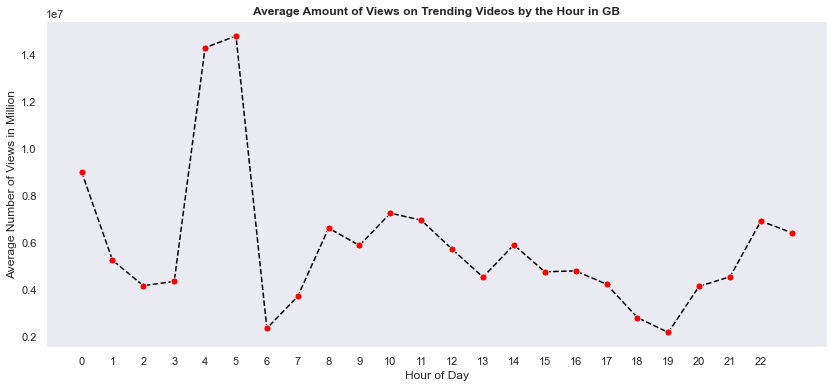

In [96]:
set_css()
def publish_hour_views_plot(data):
  by_hour = data.groupby("publish_hour").mean()
  a=np.arange(0,23)
  sns.set(rc={'figure.figsize':(14,6)})
  ax=sns.lineplot(by_hour.index, by_hour["views"],ls='dashed',color='black',marker='o',markerfacecolor='red',markersize=7)
  ax.grid(False)
  ax.set_xticks(a)
  plt.xlabel("Hour of Day")
  plt.ylabel("Average Number of Views in Million")
  plt.title("Average Amount of Views on Trending Videos by the Hour in %s" %(data.name),weight='bold')
  return 
publish_hour_views_plot(df)

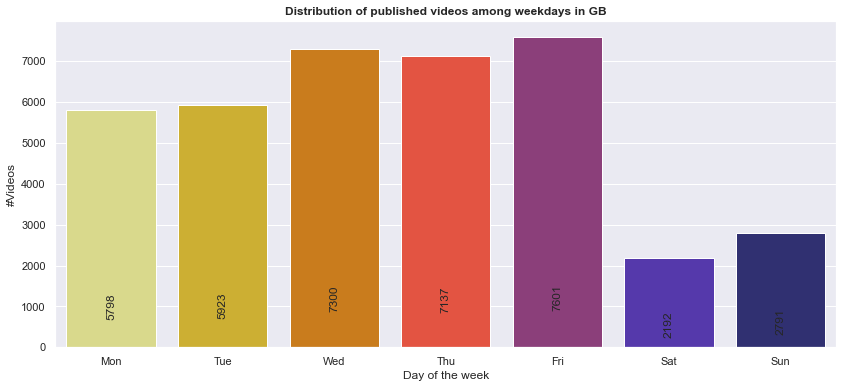

In [97]:
set_css()
def publish_day_analysis(data):
  weeklist = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
  by_day = data.publish_weekday.value_counts()
  ax=sns.barplot(by_day.index,by_day.values,palette='CMRmap_r')
  ax.set_xticklabels(weeklist)
  # print("Plot to check for\neffect of weekends\non published videos")
  plt.xlabel("Day of the week")
  plt.ylabel("#Videos")
  plt.title("Distribution of published videos among weekdays in %s" %(data.name),weight='bold')
  show_values_on_bars(ax,'v')
publish_day_analysis(df)

Most of ?

Most VIEWED or LIKED or DISLIKED Video

Enter the Year
(2018 or 2017)
or Just hit Enter2017
Choose stat
1. Views
2. Likes
3. Dislikes1


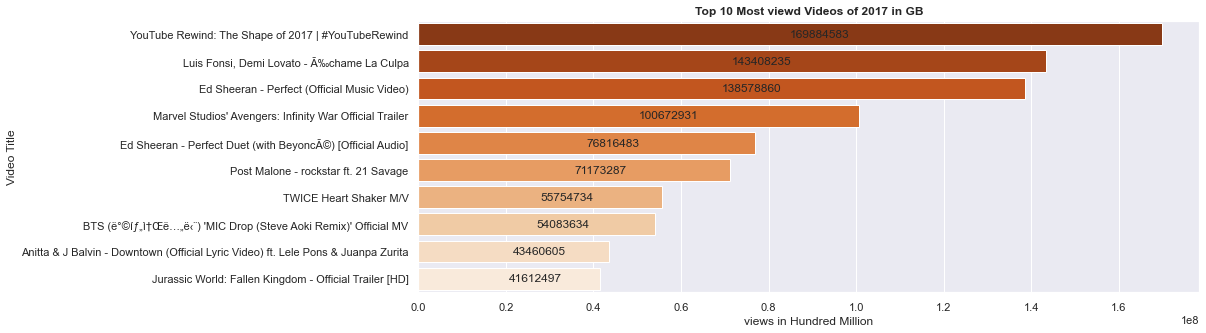

In [98]:
def plot_most_of_vids(data,*args):
  nam = data.name
  colors = {'views':'Oranges_r','likes':'Greens_r','dislikes':'Reds_r'}
  if args[1]==1:
    y = 'views'
  elif args[1]==2:
    y='likes'
  else:
    y='dislikes'
  if args[0]==None:
    data1 = data
    yr = "Combined 2017 & 2018"
  else:
    data1 = data[data['trend_year']==args[0]]
    yr = str(args[0])
  data2 = data1[['title',y]].sort_values(by=y,ascending=True)
  data2.drop_duplicates("title",keep='last',inplace=True)
  data3=data2.sort_values(by=y,ascending=False)
  data3.set_index("title")
  sns.set(rc={'figure.figsize':(14,5)})
  plot=sns.barplot(y,'title',data=data3.head(10),palette=colors[y])
  show_values_on_bars(plot,'h')
  plt.xlabel("%s in Hundred Million" %(y))
  plt.ylabel("Video Title")
  plt.title("Top 10 Most %sd Videos of %s in %s" %(y[:-1],yr,data.name),weight='bold')
set_css()
def most_of_vids(*args):
  a = input(prompt="Enter the Year\n(2018 or 2017)\nor Just hit Enter")
  b = input(prompt="Choose stat\n1. Views\n2. Likes\n3. Dislikes")
  if len(args)>0:
    x = tdf
  else:
    x = df
  if len(a)== 0:
    plot_most_of_vids(x,None,int(b))
  else:
    plot_most_of_vids(x,int(a),int(b))
most_of_vids()

Most Liked,Viewed,Disliked videos from a particular Category

##EDA Related to Channels

                       0
0          Entertainment
1         People & Blogs
2                 Sports
3                  Music
4          Howto & Style
5                 Gaming
6       Film & Animation
7        News & Politics
8                 Comedy
9        Travel & Events
10             Education
11        Pets & Animals
12  Science & Technology
13      Autos & Vehicles
14                 Shows
#Choose a Category from above
10
#Choose stat
1. Views
2. Likes
3. Dislikes1


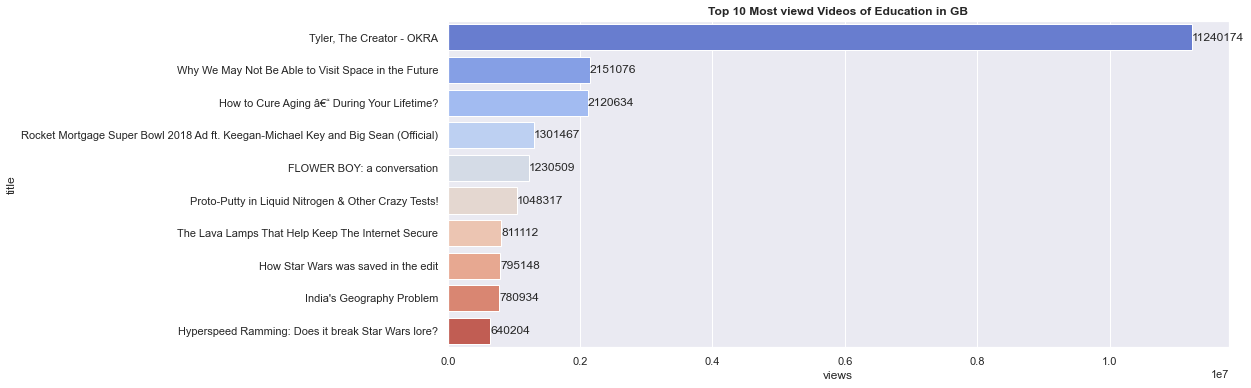

In [100]:
# set_css()
def plot_most_of_categ(data,catno,stat):
  categ = dict_cat[catno]
  if stat==1:
    y='views'
  elif stat==2:
    y='likes'
  else:
    y='dislikes'
  colors = {'views':'coolwarm','likes':'RdYlGn_r','dislikes':'YlOrRd_r'}
  data1 = data[data['category']==categ]
  data2 = data1[['title',y]].sort_values(by=y,ascending=True)
  data2.drop_duplicates("title",keep='last',inplace=True)
  data3=data2.sort_values(by=y,ascending=False)
  data3.set_index("title")
  sns.set(rc={'figure.figsize':(14,6)})
  plot=sns.barplot(y,'title',data=data3.head(10),palette=colors[y])
  plt.title("Top 10 Most %sd Videos of %s in %s" %(y[:-1],categ,data.name),weight='bold')
  show_values_on_bars(plot,'h','a')


def most_of_categ(*args):
  print(pd.DataFrame(cat_x))
  a = int(input(prompt="#Choose a Category from above\n"))
  b = int(input(prompt="#Choose stat\n1. Views\n2. Likes\n3. Dislikes"))
  if len(args)>0:
    x = tdf
  else:
    x = df
  if x.shape[0]!=0:
    plot_most_of_categ(x,a,b)
  else:
    c = input("choose one of countries").upper()
    cdf = con_dict[c]
    cdf.name = c 
    plot_most_of_categ(cdf,a,b)
most_of_categ()

Top 10 most trended channels

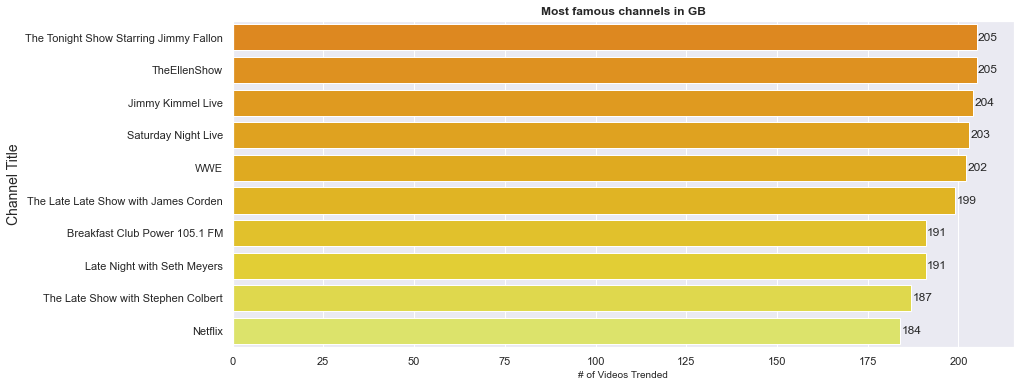

In [101]:
set_css()
def chnls_most_trenvids(data,*args): #to get the top 10 most times trended channles
  nam = data.name
  if len(list(args)) == 0:
    pass
  else:
    data = data[data['trend_year']==args[0]]
  x = data["channel_title"].value_counts()[:10] 
  sns.set(rc={'figure.figsize':(14,6)})
  splot = sns.barplot(x.values,x.index.values,palette='Wistia_r')
  show_values_on_bars(splot, "h", 0.3)
  plt.xlabel("# of Videos Trended", size=10)
  plt.ylabel("Channel Title", size=14)
  plt.title("Most famous channels in %s" %(nam),weight='bold')
chnls_most_trenvids(df)

Function to gather channel_title and its data per video

In [102]:
from collections import OrderedDict
def all_chnl_stat(data):
  count = 0
  chnl_dict=OrderedDict() # will contain data in order of Views->likes->dislikes->cmments
  chnl = data["channel_title"].unique()
  for chnl in chnl:
    chnl_dict[chnl] = []
  for i in range(len(data["views"])):
    a = data["channel_title"].iloc[i]
    chnl_dict[a].append([data["views"].loc[i],data["likes"].loc[i],data["dislikes"].loc[i],data["comment_count"].loc[i],data["title"].loc[i]])
  return chnl_dict
chnl_data = all_chnl_stat(IN.reset_index())
# chnl_data

Get the Statistics for the Given channels

In [103]:
def get_channel_stats(x,chnl_data):
  view=like=dislike=comment=maxv=maxl=indv=indl=0
  l = chnl_data[x]
  dict_a = {}
  tv = len(l)
  for i in range(len(l)):
    view = view + l[i][0]
    if (l[i][0]>maxv):
      indv = i
      maxv = l[i][0]
    like = like + l[i][1]
    if (l[i][1]>maxl):
      indl = i
      maxl = l[i][1]
    dislike = dislike + l[i][2]
    comment = comment + l[i][3]
  dict_a['total videos'] = [tv]
  dict_a['views'] = [view]
  dict_a['likes'] = [like]
  dict_a['dislikes'] = [dislike]
  dict_a['comment_count'] = [comment]
  dict_a['Avg Views per video'] = [int(view/tv)]
  dict_a['likes to dislikes ratio'] = [np.log2(int(like/dislike))]
  dict_a['MostViewed'] = [l[indv][4]]
  dict_a['MostLiked'] = [l[indl][4]]
  return pd.DataFrame(dict_a,index=[x])

In [104]:
def draw_chnl_plots(x):
  color=['Reds_r', 'Purples_r','Greens_r','Oranges_r']
  f, axes = plt.subplots(1, 4)
  sns.despine(left=True)
  f.set_size_inches(20,8)
  a = sns.barplot('channel','views',data=x,palette=color[1],ax=axes[0])
  axes[0].set_xticklabels(labels=x['channel'], rotation=90,weight='bold')
  axes[0].set_title('VIEWS',weight='bold')
  axes[0].set_ylabel('Views[In Hundred million]',weight='bold')
  show_values_on_bars(a,'v')
  b=sns.barplot('channel','likes',data=x,palette=color[2],ax=axes[1])
  axes[1].set_title('LIKES',weight='bold')
  axes[1].set_xticklabels(labels=x['channel'], rotation=90,weight='bold')
  axes[1].set_ylabel('Likes[In Ten million]',weight='bold')
  show_values_on_bars(b,'v')
  splot = sns.barplot('channel','dislikes',data=x,palette=color[0],ax=axes[2])
  axes[2].set_xticklabels(labels=x['channel'], rotation=90,weight='bold')
  axes[2].set_title('DISLIKES',weight='bold')
  axes[2].set_ylabel('Dislikes',weight='bold')
  show_values_on_bars(splot,'v')
  splot1 = sns.barplot('channel','Avg Views per video',data=x,palette=color[3],ax=axes[3])
  axes[3].set_xticklabels(labels=x['channel'], rotation=90,weight='bold')
  axes[3].set_title('AVG VIEWS',weight='bold')
  axes[3].set_ylabel('Avg Views [In Million]',weight='bold')
  show_values_on_bars(splot1,'v')
  f.tight_layout()

,total videos,views,likes,dislikes,comment_count,Avg Views per video,likes to dislikes ratio,MostViewed,MostLiked
SET India,195,183495361,1884842,172219,132820,941001,3.321928,Family Time With Kapil Sharma Coming Soon On S...,Family Time With Kapil Sharma Coming Soon On S...
ETV Plus India,203,94211046,606079,93948,130377,464093,2.584963,Anubhavinchu Raja | 24th February 2018 | Full ...,Anubhavinchu Raja | 24th February 2018 | Full ...
Flowers Comedy,201,133679800,976972,108449,183408,665073,3.169925,Uppum Mulakumâ”‚Flowersâ”‚EP# 605,Uppum Mulakumâ”‚Flowersâ”‚EP# 605
Technical Guruji,186,95135802,10878209,342583,6270761,511482,4.954196,Samsung Galaxy J6 Unboxing and Giveaway ðŸ”¥ðŸ...,Samsung Galaxy J6 Unboxing and Giveaway ðŸ”¥ðŸ...


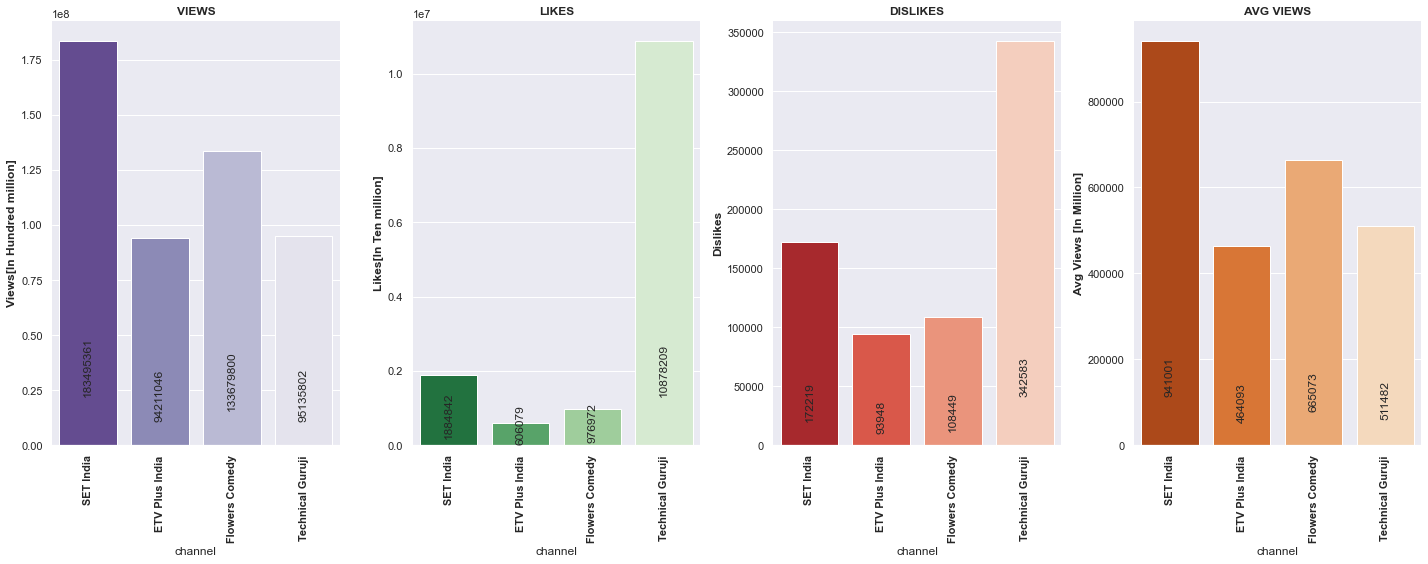

In [105]:
def compare_stats_chnls(*args):
  c_df = pd.DataFrame()
  c_df = get_channel_stats(args[0],chnl_data)
  for i in range(1,len(args)):
    c_df = c_df.append(get_channel_stats(args[i],chnl_data))
  x = c_df
  x['channel'] = x.index
  draw_chnl_plots(x)
  return x.drop(columns='channel',axis=1)
compare_stats_chnls('SET India','ETV Plus India','Flowers Comedy','Technical Guruji')